In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import pickle

print("Loading Reviews.csv - Amazon Food Reviews...")
df = pd.read_csv('Reviews.csv')

print(f"Total reviews: {len(df):,}")
print(f"\nScore distribution:")
print(df['Score'].value_counts().sort_index())

# Map scores to 3-class sentiment
# 1-2 stars -> negative
# 3 stars -> neutral  
# 4-5 stars -> positive
df['label'] = df['Score'].map({
    1: 'negative', 2: 'negative',
    3: 'neutral',
    4: 'positive', 5: 'positive'
})

# Use Text column for reviews
df = df[['Text', 'label']].copy()
df.columns = ['text', 'label']
df = df.dropna()

print(f"\n3-Class sentiment distribution:")
print(df['label'].value_counts())

# Balance the dataset - sample equal amounts from each class
min_samples = df['label'].value_counts().min()
print(f"\nBalancing to {min_samples:,} samples per class...")

df_balanced = pd.concat([
    df[df['label'] == 'negative'].sample(n=min_samples, random_state=42),
    df[df['label'] == 'neutral'].sample(n=min_samples, random_state=42),
    df[df['label'] == 'positive'].sample(n=min_samples, random_state=42)
], ignore_index=True)

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nFinal balanced dataset: {len(df_balanced):,} samples")
print(df_balanced['label'].value_counts())

Loading Reviews.csv - Amazon Food Reviews...
Total reviews: 568,454

Score distribution:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64
Total reviews: 568,454

Score distribution:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64

3-Class sentiment distribution:
label
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64

Balancing to 42,640 samples per class...

Final balanced dataset: 127,920 samples
label
neutral     42640
negative    42640
positive    42640
Name: count, dtype: int64

3-Class sentiment distribution:
label
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64

Balancing to 42,640 samples per class...

Final balanced dataset: 127,920 samples
label
neutral     42640
negative    42640
positive    42640
Name: count, dtype: int64


In [54]:
# Map labels to numeric IDs
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

df_balanced["label_id"] = df_balanced["label"].map(label2id)

# Split features and labels
X = df_balanced["text"]
y = df_balanced["label_id"]

print("Labels mapped successfully!")
print(f"Unique label IDs: {sorted(y.unique())}")

Labels mapped successfully!
Unique label IDs: [np.int64(0), np.int64(1), np.int64(2)]


In [55]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Training samples: 102,336
Test samples: 25,584


In [56]:
# Convert text to TF-IDF features
print("Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    lowercase=True,
    strip_accents='unicode'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_):,}")

Vectorizing text with TF-IDF...
TF-IDF shape: (102336, 5000)
Vocabulary size: 5,000
TF-IDF shape: (102336, 5000)
Vocabulary size: 5,000


In [57]:
# Train XGBoost model
print("Training XGBoost model...")

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    early_stopping_rounds=10,
    verbosity=1
)

# Train with evaluation set
model.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_test_tfidf, y_test)],
    verbose=True
)

print("\nTraining completed!")

Training XGBoost model...
[0]	validation_0-mlogloss:1.07989
[0]	validation_0-mlogloss:1.07989
[1]	validation_0-mlogloss:1.06309
[1]	validation_0-mlogloss:1.06309
[2]	validation_0-mlogloss:1.05047
[2]	validation_0-mlogloss:1.05047
[3]	validation_0-mlogloss:1.03611
[3]	validation_0-mlogloss:1.03611
[4]	validation_0-mlogloss:1.02418
[4]	validation_0-mlogloss:1.02418
[5]	validation_0-mlogloss:1.01307
[5]	validation_0-mlogloss:1.01307
[6]	validation_0-mlogloss:1.00231
[6]	validation_0-mlogloss:1.00231
[7]	validation_0-mlogloss:0.99245
[7]	validation_0-mlogloss:0.99245
[8]	validation_0-mlogloss:0.98295
[8]	validation_0-mlogloss:0.98295
[9]	validation_0-mlogloss:0.97504
[9]	validation_0-mlogloss:0.97504
[10]	validation_0-mlogloss:0.96666
[10]	validation_0-mlogloss:0.96666
[11]	validation_0-mlogloss:0.95924
[11]	validation_0-mlogloss:0.95924
[12]	validation_0-mlogloss:0.95273
[12]	validation_0-mlogloss:0.95273
[13]	validation_0-mlogloss:0.94624
[13]	validation_0-mlogloss:0.94624
[14]	validatio

In [58]:
# Make predictions
from sklearn.metrics import precision_recall_fscore_support

y_pred = model.predict(X_test_tfidf)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("📊 XGBoost Sentiment Model Performance")
print("=" * 40)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nConfusion Matrix:")
print("         Neg  Neu  Pos")
for i, row in enumerate(cm):
    print(f"{id2label[i]:8} {row[0]:4} {row[1]:4} {row[2]:4}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

📊 XGBoost Sentiment Model Performance
Accuracy:  0.7326
Precision: 0.7344
Recall:    0.7326
F1-score:  0.7332

Confusion Matrix:
         Neg  Neu  Pos
negative 6149 1735  644
neutral  1466 5973 1089
positive  621 1287 6620

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.72      0.73      8528
     neutral       0.66      0.70      0.68      8528
    positive       0.79      0.78      0.78      8528

    accuracy                           0.73     25584
   macro avg       0.73      0.73      0.73     25584
weighted avg       0.73      0.73      0.73     25584



In [59]:
# Test with custom examples
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    pred_id = model.predict(text_tfidf)[0]
    pred_proba = model.predict_proba(text_tfidf)[0]
    
    return {
        'label': id2label[pred_id],
        'confidence': float(pred_proba[pred_id]),
        'probabilities': {
            'negative': float(pred_proba[0]),
            'neutral': float(pred_proba[1]),
            'positive': float(pred_proba[2])
        }
    }

# Test examples
test_texts = [
    "I love this product! It's amazing!",
    "Worst purchase ever. Total waste of money.",
    "The product is okay, nothing special.",
    "Absolutely terrible experience, never again!",
    "Best decision I've ever made, highly recommend!"
]

print("🔮 Testing Custom Examples:\n")
for text in test_texts:
    result = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted: {result['label']} (confidence: {result['confidence']:.2%})")
    print(f"Probabilities: Neg={result['probabilities']['negative']:.2%}, "
          f"Neu={result['probabilities']['neutral']:.2%}, "
          f"Pos={result['probabilities']['positive']:.2%}")
    print("-" * 60)

🔮 Testing Custom Examples:

Text: I love this product! It's amazing!
Predicted: positive (confidence: 85.85%)
Probabilities: Neg=8.08%, Neu=6.08%, Pos=85.85%
------------------------------------------------------------
Text: Worst purchase ever. Total waste of money.
Predicted: negative (confidence: 94.36%)
Probabilities: Neg=94.36%, Neu=2.06%, Pos=3.58%
------------------------------------------------------------
Text: The product is okay, nothing special.
Predicted: neutral (confidence: 61.00%)
Probabilities: Neg=24.07%, Neu=61.00%, Pos=14.92%
------------------------------------------------------------
Text: Absolutely terrible experience, never again!
Predicted: negative (confidence: 80.18%)
Probabilities: Neg=80.18%, Neu=5.52%, Pos=14.30%
------------------------------------------------------------
Text: Best decision I've ever made, highly recommend!
Predicted: positive (confidence: 76.36%)
Probabilities: Neg=18.05%, Neu=5.59%, Pos=76.36%
-----------------------------------------

In [60]:
# Save the model and vectorizer
import pickle

# Save XGBoost model
model.save_model('xgboost_sentiment_model.json')

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save label mappings
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({'label2id': label2id, 'id2label': id2label}, f)

print("✅ Model saved successfully!")
print("   - xgboost_sentiment_model.json")
print("   - tfidf_vectorizer.pkl")
print("   - label_mappings.pkl")

✅ Model saved successfully!
   - xgboost_sentiment_model.json
   - tfidf_vectorizer.pkl
   - label_mappings.pkl


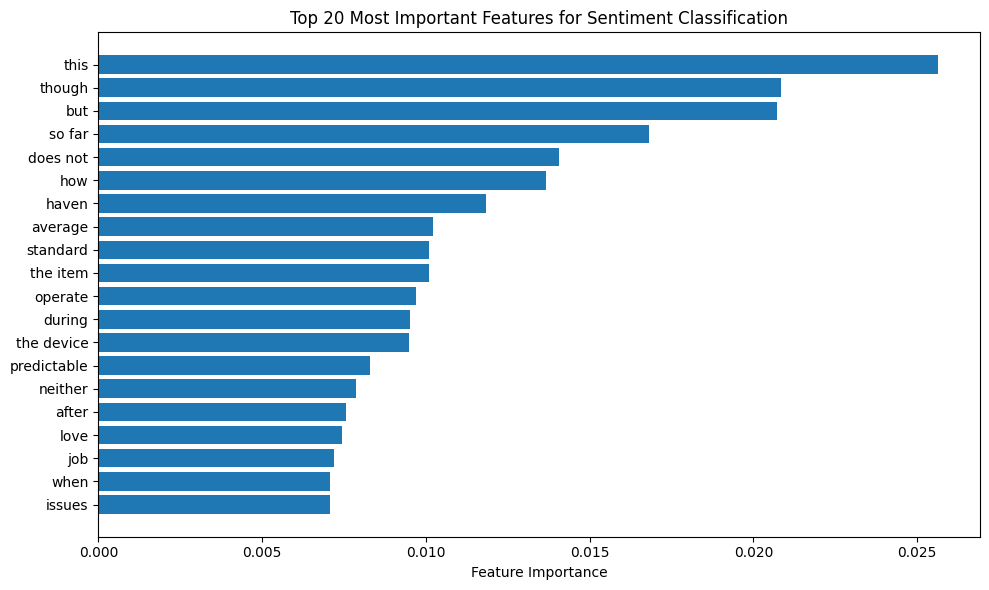


Top 10 Most Important Features:
1. this: 0.0256
2. though: 0.0209
3. but: 0.0207
4. so far: 0.0168
5. does not: 0.0140
6. how: 0.0137
7. haven: 0.0118
8. average: 0.0102
9. standard: 0.0101
10. the item: 0.0101


In [10]:
# Feature importance analysis
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
# Get top 20 features
top_indices = feature_importance.argsort()[-20:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_importance = [feature_importance[i] for i in top_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importance, align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features for Sentiment Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i in range(10):
    print(f"{i+1}. {top_features[i]}: {top_importance[i]:.4f}")